* https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
* https://ntguardian.wordpress.com/2016/09/26/introduction-stock-market-data-python-2/

* pandas에서 yahoo의 주식 정보 바로 가져오기 --> pandas_datareader.data

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2016, 1, 1)
end = datetime.date.today()
apple = web.DataReader("AAPL", "yahoo", start, end)

In [1] used 32.2852 MiB RAM in 1.90s, peaked 0.00 MiB above current, total RAM usage 124.68 MiB


In [2]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,107.010002,107.029999,104.820000,105.260002,101.339394,40635300
2016-01-04,102.610001,105.370003,102.000000,105.349998,101.426033,67649400
2016-01-05,105.750000,105.849998,102.410004,102.709999,98.884369,55791000
2016-01-06,100.559998,102.370003,99.870003,100.699997,96.949242,68457400
2016-01-07,98.680000,100.129997,96.430000,96.449997,92.857529,81094400


In [2] used 0.1328 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 124.82 MiB


Populating the interactive namespace from numpy and matplotlib


/Users/1003946/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'divide', 'random', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


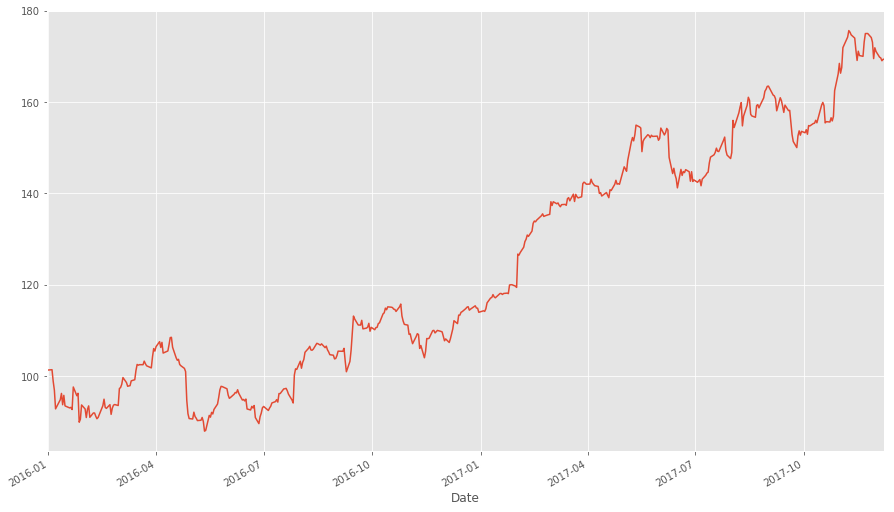

In [3] used 10.0195 MiB RAM in 0.48s, peaked 0.00 MiB above current, total RAM usage 134.84 MiB


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

apple["Adj Close"].plot(grid=True)

* matplotlib를 이용해 주식 candle stick graph 그리기

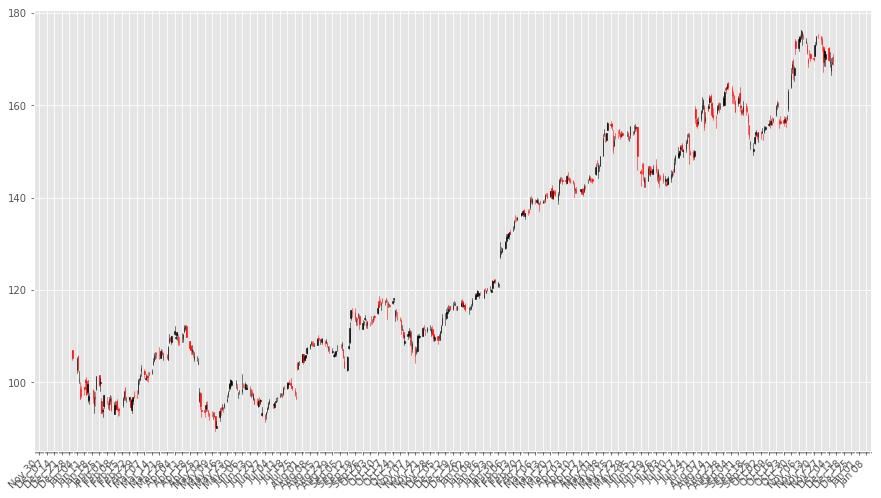

In [4] used 80.7578 MiB RAM in 4.24s, peaked 0.00 MiB above current, total RAM usage 215.59 MiB


In [4]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

* 서로 다른 종목 비교하기
 * scale이 달라 절대값을 비교하기 어려우므로, 시작점으로부터 얼마나 변화했는지 변화율을 보는 것이 한 방법.

In [5]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2015-12-31,101.339394,758.880005,52.818901
2016-01-04,101.426033,741.840027,52.171520
2016-01-05,98.884369,742.580017,52.409531
2016-01-06,96.949242,743.619995,51.457489
2016-01-07,92.857529,726.390015,49.667664


In [5] used 1.7070 MiB RAM in 2.89s, peaked 0.00 MiB above current, total RAM usage 217.30 MiB


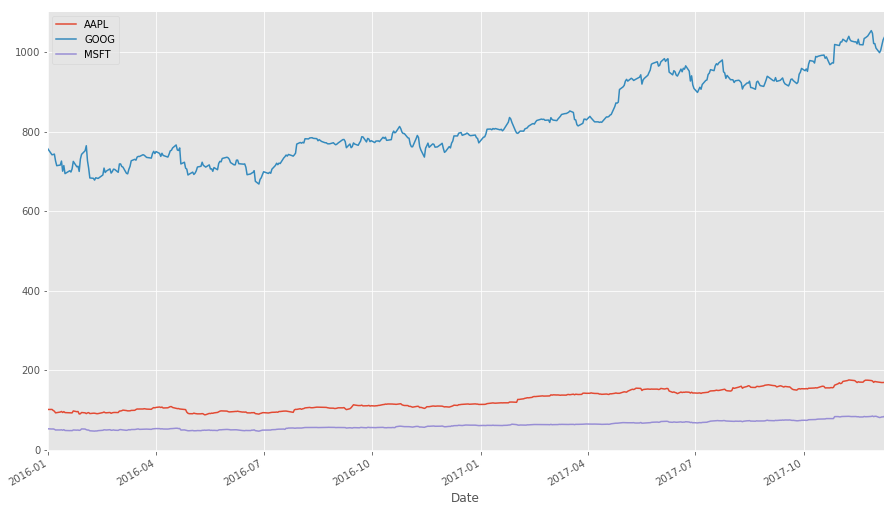

In [6] used 2.0469 MiB RAM in 0.42s, peaked 0.00 MiB above current, total RAM usage 219.35 MiB


In [6]:
stocks.plot(grid = True)

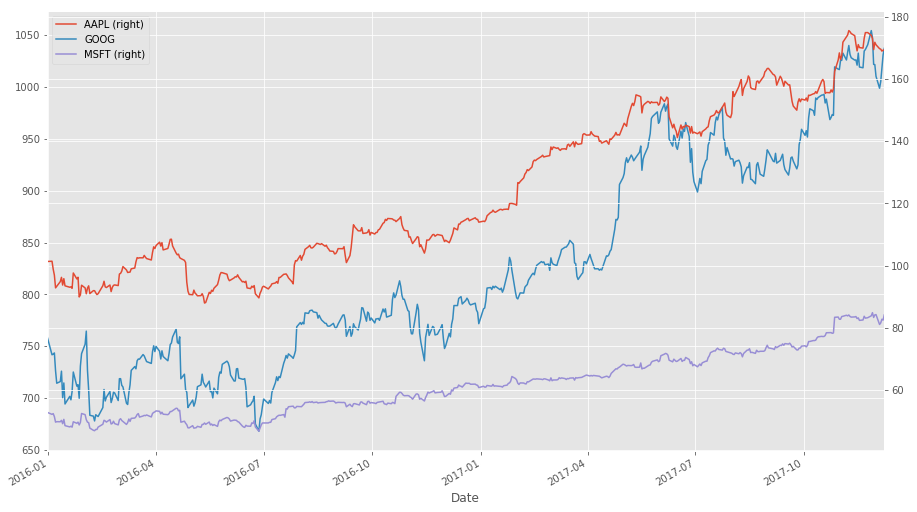

In [7] used 3.5547 MiB RAM in 0.57s, peaked 0.00 MiB above current, total RAM usage 222.90 MiB


In [7]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [8]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2015-12-31,1.000000,1.000000,1.000000
2016-01-04,1.000855,0.977546,0.987743
2016-01-05,0.975774,0.978521,0.992250
2016-01-06,0.956679,0.979891,0.974225
2016-01-07,0.916302,0.957187,0.940339


In [8] used 0.1602 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 223.06 MiB


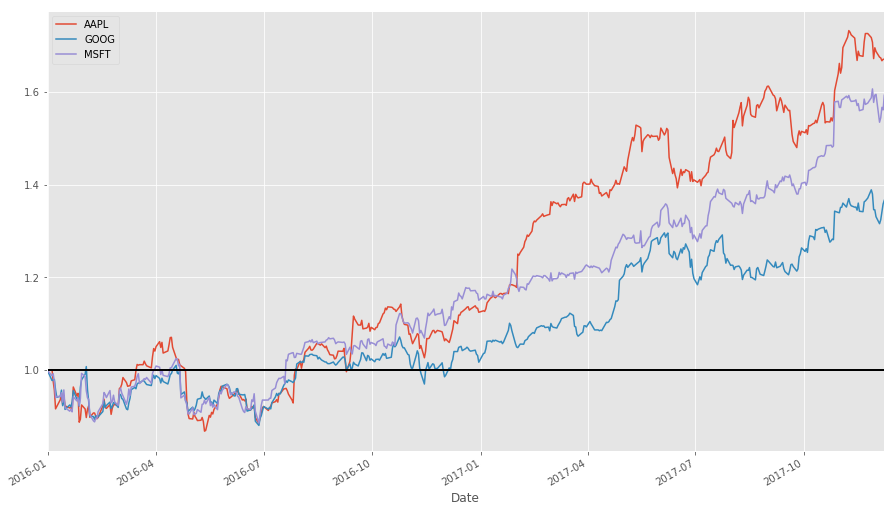

In [9] used 3.1914 MiB RAM in 0.43s, peaked 0.00 MiB above current, total RAM usage 226.25 MiB


In [9]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [10]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2015-12-31,NaN,NaN,NaN
2016-01-04,0.000855,-0.022710,-0.012332
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402


In [10] used 0.0273 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 226.28 MiB


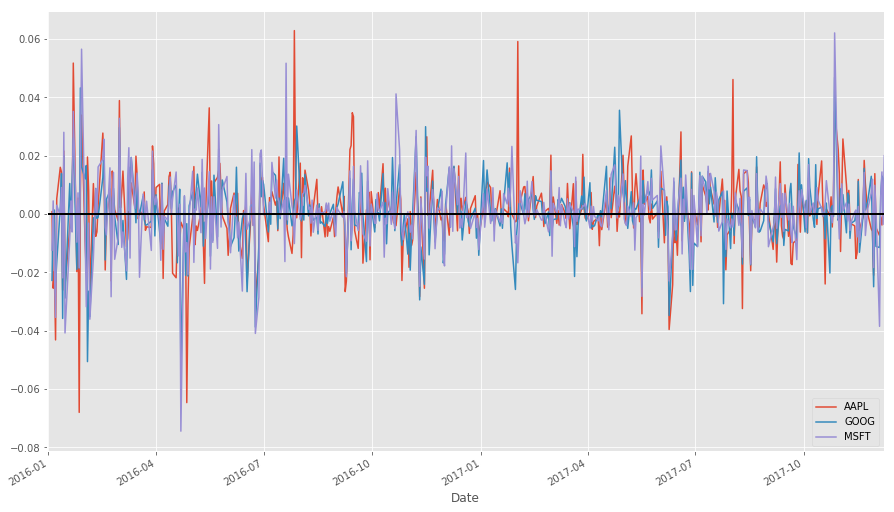

In [11] used 3.8242 MiB RAM in 0.50s, peaked 0.00 MiB above current, total RAM usage 230.11 MiB


In [11]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

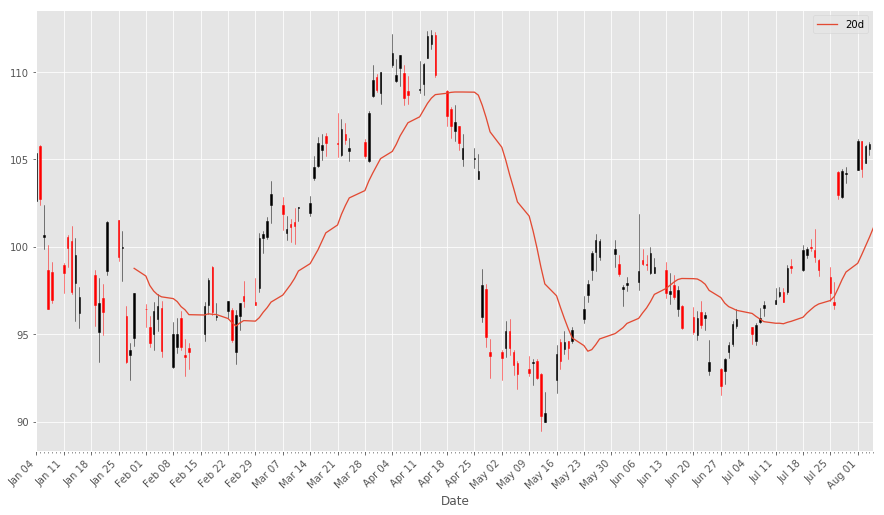

In [12] used 3.2461 MiB RAM in 1.57s, peaked 0.00 MiB above current, total RAM usage 233.35 MiB


In [12]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

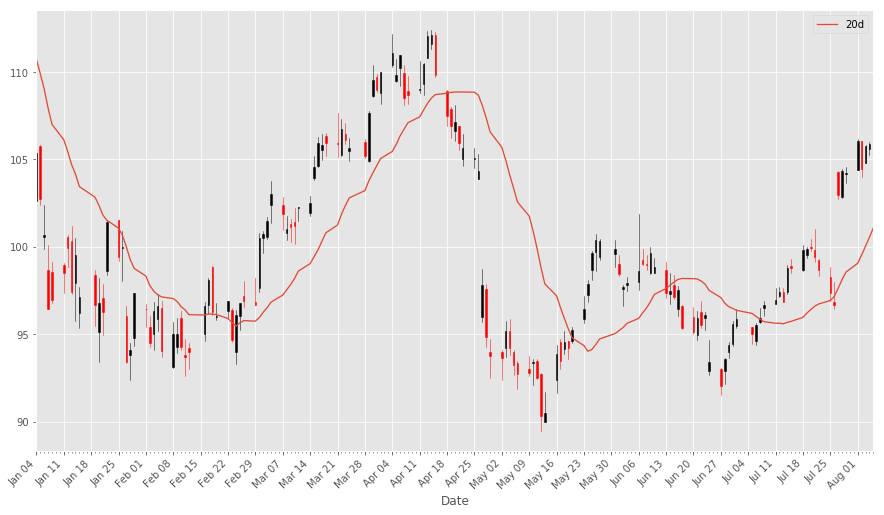

In [13] used -0.8555 MiB RAM in 3.32s, peaked 1.26 MiB above current, total RAM usage 232.50 MiB


In [13]:
start = datetime.datetime(2010,1,1)
apple = web.DataReader("AAPL", "yahoo", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

* 주식의 추세를 살피기 위해 두 기간 (긴 기간(200일)과 짧은 기간(50일)의 Moving Average를 비교
 * MA는 .rolling 함수를 이용해서 구할 수 있다.

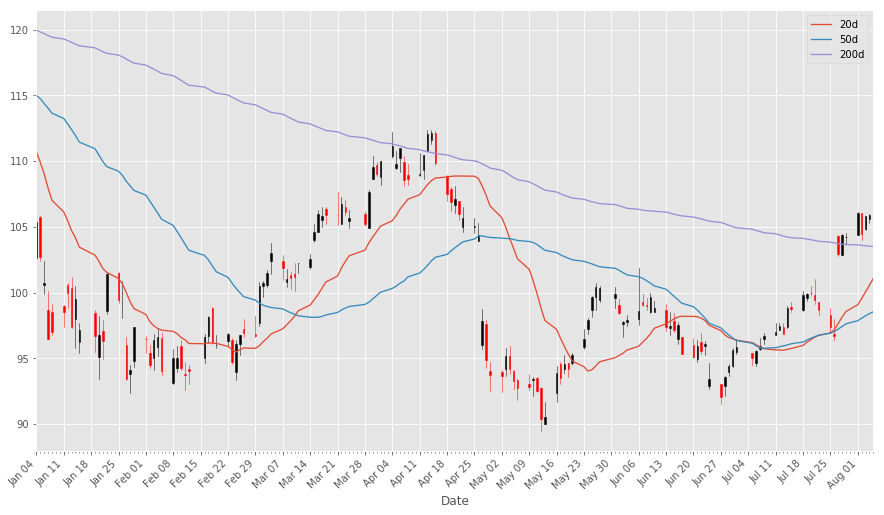

In [14] used 0.1836 MiB RAM in 1.62s, peaked 0.00 MiB above current, total RAM usage 232.68 MiB


In [14]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])

In [15]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Adj Close,Volume,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2017-12-04,172.479996,172.619995,169.630005,169.800003,169.800003,32542400,172.69,163.97,152.90,8.72
2017-12-05,169.059998,171.520004,168.399994,169.639999,169.639999,27350200,172.46,164.36,153.07,8.10
2017-12-06,167.500000,170.199997,166.460007,169.009995,169.009995,28560000,172.17,164.67,153.23,7.50
2017-12-07,169.029999,170.440002,168.910004,169.320007,169.320007,25673300,171.83,164.97,153.39,6.86
2017-12-08,170.490005,171.000000,168.820007,169.369995,169.369995,23173700,171.50,165.30,153.55,6.20


In [15] used 0.0234 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 232.70 MiB


* MA 변화량 비교
 * 짧은 기간 MA > 긴 기간 MA: 앞으로 상승할 가능성이 크다.
 * 짧은 기간 MA < 긴 기간 MA: 앞으로 하락할 가능성이 크다.
* 상승할 기간의 regime을 1, 하락할 곳을 0으로 지정.

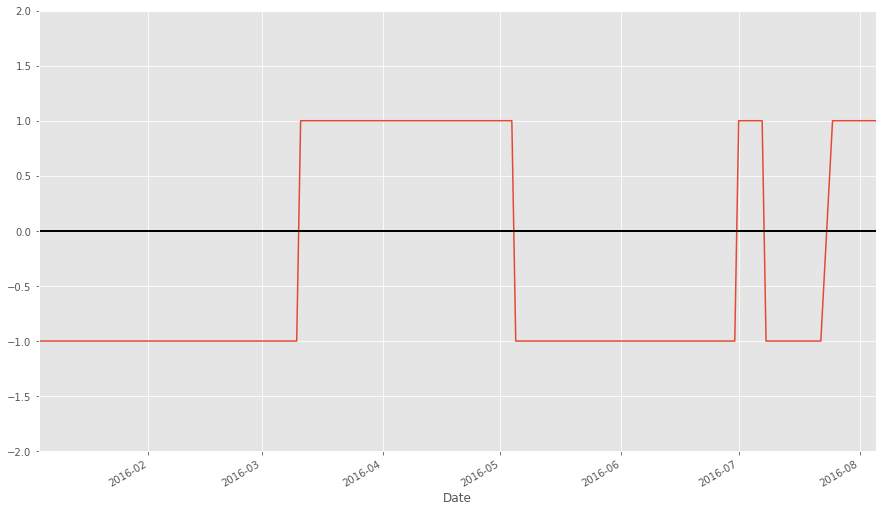

In [17] used 1.5586 MiB RAM in 0.39s, peaked 0.00 MiB above current, total RAM usage 234.31 MiB


In [17]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-01':'2016-08-07',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

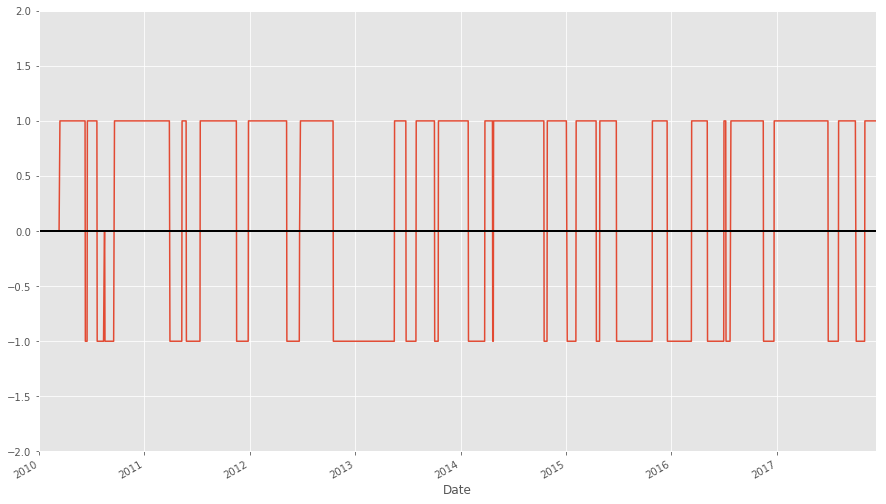

In [18] used 1.7109 MiB RAM in 0.40s, peaked 0.00 MiB above current, total RAM usage 236.02 MiB


In [18]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [19]:
apple["Regime"].value_counts()

 1    1261
-1     686
 0      53
Name: Regime, dtype: int64

In [19] used 0.0117 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 236.03 MiB


* regigm의 변화로 buy / sell 결정
 * -1 -> 1로 변화: buy
 * 1 -> -1로 변화: sell
 * 기타: 보류

In [20]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

/Users/1003946/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


,Open,High,Low,Close,Adj Close,Volume,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2017-12-04,172.479996,172.619995,169.630005,169.800003,169.800003,32542400,172.69,163.97,152.90,8.72,1.0,0.0
2017-12-05,169.059998,171.520004,168.399994,169.639999,169.639999,27350200,172.46,164.36,153.07,8.10,1.0,0.0
2017-12-06,167.500000,170.199997,166.460007,169.009995,169.009995,28560000,172.17,164.67,153.23,7.50,1.0,0.0
2017-12-07,169.029999,170.440002,168.910004,169.320007,169.320007,25673300,171.83,164.97,153.39,6.86,1.0,0.0
2017-12-08,170.490005,171.000000,168.820007,169.369995,169.369995,23173700,171.50,165.30,153.55,6.20,1.0,-1.0


In [20] used 0.0547 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 236.09 MiB


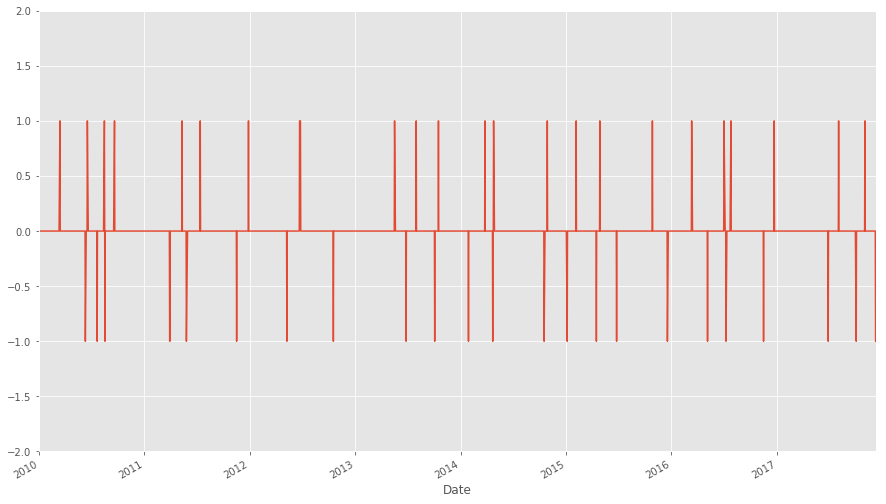

In [21] used 1.7266 MiB RAM in 0.40s, peaked 0.00 MiB above current, total RAM usage 237.81 MiB


In [21]:
apple["Signal"].plot(ylim = (-2, 2))

In [22]:
apple["Signal"].value_counts()

 0.0    1951
-1.0      24
 1.0      24
Name: Signal, dtype: int64

In [22] used 0.0547 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 237.87 MiB


In [23]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2010-03-15     31.977142
2010-06-18     39.152859
2010-08-16     35.377144
2010-09-20     40.461430
2011-05-12     49.509998
2011-07-14     51.110001
2011-12-28     57.520000
2012-06-22     83.157143
2012-06-25     81.538574
2013-05-17     61.894287
2013-07-31     64.647141
2013-10-16     71.587143
2014-03-26     77.111427
2014-04-25     81.705711
2014-10-28    106.739998
2015-02-05    119.940002
2015-04-28    130.559998
2015-10-27    114.550003
2016-03-11    102.260002
2016-07-01     95.889999
2016-07-25     97.339996
2016-12-22    116.290001
2017-08-02    157.139999
2017-11-01    166.889999
Name: Close, dtype: float64

In [23] used 0.0391 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 237.91 MiB


In [24]:
apple.loc[apple["Signal"] == -1, "Close"]

Date
2010-06-11     36.215714
2010-07-22     37.002857
2010-08-18     36.152859
2011-03-30     49.804287
2011-03-31     49.787144
2011-05-27     48.201427
2011-11-17     53.915714
2012-05-09     81.311432
2012-10-17     92.087143
2013-06-26     56.867142
2013-10-03     69.058571
2014-01-28     72.357140
2014-04-22     75.957146
2014-10-17     97.669998
2015-01-05    106.250000
2015-04-16    126.169998
2015-06-25    127.500000
2015-12-18    106.029999
2016-05-05     93.239998
2016-07-08     96.680000
2016-11-15    107.110001
2017-06-27    143.729996
2017-10-02    153.809998
2017-12-08    169.369995
Name: Close, dtype: float64

In [24] used 0.0195 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 237.93 MiB


In [25]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-15,31.977142,1.0,Buy
2010-06-11,36.215714,-1.0,Sell
2010-06-18,39.152859,1.0,Buy
2010-07-22,37.002857,-1.0,Sell
2010-08-16,35.377144,0.0,Buy
2010-08-18,36.152859,-1.0,Sell
2010-09-20,40.461430,1.0,Buy
2011-03-30,49.804287,0.0,Sell
2011-03-31,49.787144,-1.0,Sell


In [25] used 0.0352 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 237.96 MiB


In [26]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2010-03-15,2010-06-11,31.977142,4.238572
2010-06-18,2010-07-22,39.152859,-2.150002
2010-09-20,2011-03-30,40.461430,9.342857
2011-05-12,2011-05-27,49.509998,-1.308571
2011-07-14,2011-11-17,51.110001,2.805713
2011-12-28,2012-05-09,57.520000,23.791432
2012-06-25,2012-10-17,81.538574,10.548569
2013-05-17,2013-06-26,61.894287,-5.027145
2013-07-31,2013-10-03,64.647141,4.411430


In [26] used 0.0469 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 238.01 MiB


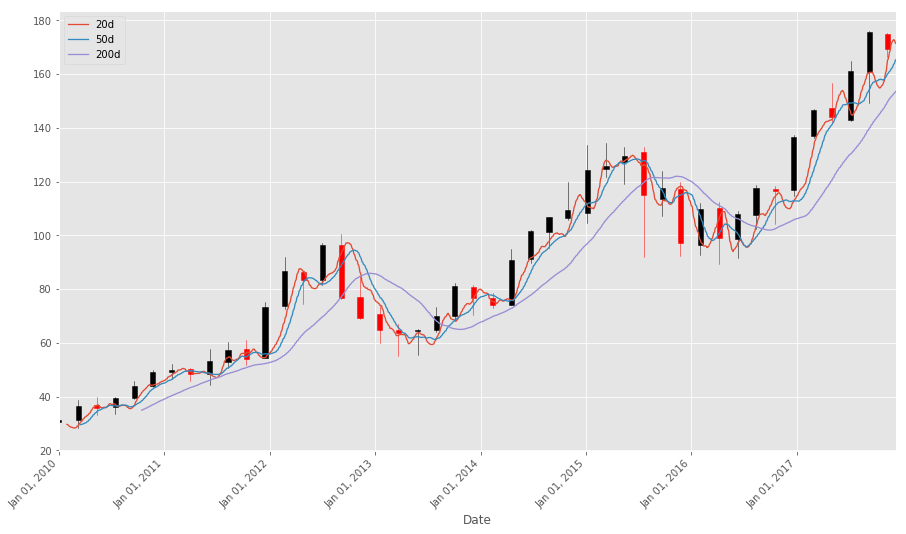

In [27] used 1.9336 MiB RAM in 0.90s, peaked 0.00 MiB above current, total RAM usage 239.94 MiB


In [27]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

/Users/1003946/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


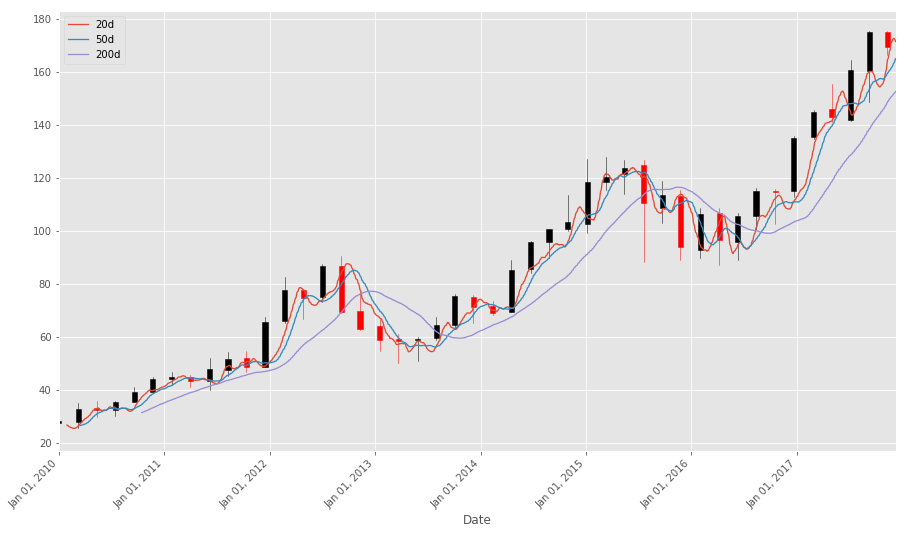

In [28] used 1.7148 MiB RAM in 0.70s, peaked 0.00 MiB above current, total RAM usage 241.66 MiB


In [28]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [29]:
apple_adj_long_profits

,End Date,Price,Profit
Date,,,
2010-03-15,2010-06-11,28.665380,3.799590
2010-06-18,2010-07-22,35.097935,-1.927334
2010-09-20,2011-03-30,36.270973,8.375256
2011-05-12,2011-05-27,44.382416,-1.173054
2011-07-14,2011-11-17,45.816708,2.515144
2011-12-28,2012-05-09,51.562847,21.327419
2012-06-25,2012-10-17,73.093903,9.810508
2013-05-17,2013-06-26,56.675735,-4.603286
2013-07-31,2013-10-04,59.196491,4.406983


In [29] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 241.66 MiB


In [30]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2010-03-15,2010-06-11,28.665380,3.799590,25.516340
2010-06-18,2010-07-22,35.097935,-1.927334,30.683642
2010-09-20,2011-03-30,36.270973,8.375256,35.217031
2011-05-12,2011-05-27,44.382416,-1.173054,42.186160
2011-07-14,2011-11-17,45.816708,2.515144,45.208427
2011-12-28,2012-05-09,51.562847,21.327419,51.290084
2012-06-25,2012-10-17,73.093903,9.810508,72.433113
2013-05-17,2013-06-26,56.675735,-4.603286,51.757193
2013-07-31,2013-10-04,59.196491,4.406983,58.790974


In [30] used 0.0000 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 241.66 MiB


In [31]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2010-03-15,2010-06-11,1.012919e+06,3.799590,28.665380,3400.0,1.000000e+06,0.0,12918.6060,97462.2920
2010-06-18,2010-07-22,1.007522e+06,-1.927334,35.097935,2800.0,1.012919e+06,0.0,-5396.5352,98274.2180
2010-09-20,2011-03-30,1.030135e+06,8.375256,36.270973,2700.0,1.007522e+06,0.0,22613.1912,97931.6271
2011-05-12,2011-05-27,1.027437e+06,-1.173054,44.382416,2300.0,1.030135e+06,0.0,-2698.0242,102079.5568
2011-07-14,2011-11-17,1.032971e+06,2.515144,45.816708,2200.0,1.027437e+06,0.0,5533.3168,100796.7576
2011-12-28,2012-05-09,1.075625e+06,21.327419,51.562847,2000.0,1.032971e+06,0.0,42654.8380,103125.6940
2012-06-25,2012-10-17,1.089360e+06,9.810508,73.093903,1400.0,1.075625e+06,0.0,13734.7112,102331.4642
2013-05-17,2013-06-26,1.080614e+06,-4.603286,56.675735,1900.0,1.089360e+06,0.0,-8746.2434,107683.8965
2013-07-31,2013-10-04,1.088546e+06,4.406983,59.196491,1800.0,1.080614e+06,0.0,7932.5694,106553.6838
2013-10-16,2014-01-28,1.090305e+06,1.099114,65.984161,1600.0,1.088546e+06,0.0,1758.5824,105574.6576


In [31] used 0.0000 MiB RAM in 0.22s, peaked 0.00 MiB above current, total RAM usage 241.66 MiB


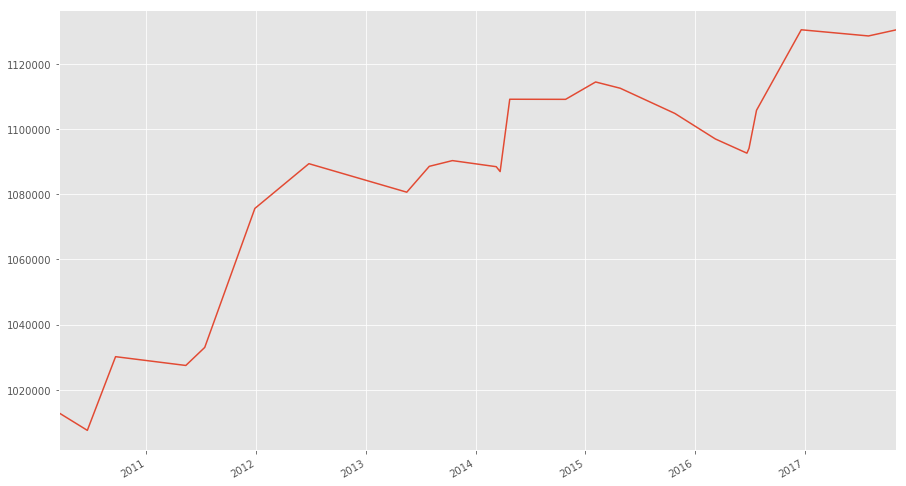

In [32] used 0.0000 MiB RAM in 0.37s, peaked 0.00 MiB above current, total RAM usage 241.66 MiB


In [32]:
apple_backtest["End Port. Value"].plot()

* 여러 종목에 대해 simulation

In [34]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].ix[-1, "Regime"]
        s[1].ix[-1, "Regime"] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].ix[-1, "Regime"] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results
 
# Get more stocks
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
facebook = web.DataReader("FB", "yahoo", start, end)
twitter = web.DataReader("TWTR", "yahoo", start, end)
netflix = web.DataReader("NFLX", "yahoo", start, end)
amazon = web.DataReader("AMZN", "yahoo", start, end)
#yahoo = web.DataReader("YHOO", "yahoo", start, end)
sony = web.DataReader("SNY", "yahoo", start, end)
nintendo = web.DataReader("NTDOY", "yahoo", start, end)
ibm = web.DataReader("IBM", "yahoo", start, end)
hp = web.DataReader("HPQ", "yahoo", start, end)

In [34] used -0.3281 MiB RAM in 15.47s, peaked 0.79 MiB above current, total RAM usage 237.19 MiB


In [36]:
signals = ma_crossover_orders([("AAPL", ohlc_adj(apple)),
                              ("MSFT",  ohlc_adj(microsoft)),
                              ("GOOG",  ohlc_adj(google)),
                              ("FB",    ohlc_adj(facebook)),
                              ("TWTR",  ohlc_adj(twitter)),
                              ("NFLX",  ohlc_adj(netflix)),
                              ("AMZN",  ohlc_adj(amazon)),
                              ("SNY",   ohlc_adj(sony)),
                              ("NTDOY", ohlc_adj(nintendo)),
                              ("IBM",   ohlc_adj(ibm)),
                              ("HPQ",   ohlc_adj(hp))],
                            fast = 20, slow = 50)
signals

/Users/1003946/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


Price  Regime Signal
Date       Symbol                            
2010-03-15 AAPL      28.665380     1.0    Buy
           AMZN     131.130005    -1.0   Sell
           GOOG     279.770355    -1.0   Sell
           HPQ       19.554564     1.0    Buy
           IBM      104.789513     1.0    Buy
           MSFT      23.911312    -1.0   Sell
           NFLX       9.942857     1.0    Buy
           NTDOY     33.576061     1.0    Buy
           SNY       27.891596    -1.0   Sell
2010-03-16 AMZN     131.789993     1.0    Buy
2010-03-22 GOOG     276.948730     1.0    Buy
2010-03-23 MSFT      24.392967     1.0    Buy
           SNY       27.595032     1.0    Buy
2010-04-20 SNY       26.488333    -1.0   Sell
2010-05-03 GOOG     263.585632    -1.0   Sell
2010-05-10 HPQ       18.316084    -1.0   Sell
2010-05-17 NTDOY     32.853905    -1.0   Sell
2010-05-19 AMZN     124.589996    -1.0   Sell
           MSFT      23.158163    -1.0   Sell
2010-05-21 IBM      103.340904    -1.0   Sell
2010-06-11 AAPL      32.464970    -1.0   Sell
2010-06-18 AAPL      35.097935     1.0    Buy
2010-06-28 IBM      106.274200     1.0    Buy
2010-07-01 IBM      100.992607    -1.0   Sell
2010-07-06 IBM      101.725929     1.0    Buy
2010-07-07 SNY       22.759323     1.0    Buy
2010-07-09 NTDOY     34.205460     1.0    Buy
2010-07-20 IBM      104.271996    -1.0   Sell
2010-07-22 AAPL      33.170601    -1.0   Sell
2010-07-28 IBM      105.821045     1.0    Buy
2010-07-29 NFLX      14.002857    -1.0   Sell
           NTDOY     31.530127    -1.0   Sell
2010-08-02 HPQ       17.771730     1.0    Buy
2010-08-03 GOOG     243.332352     1.0    Buy
           MSFT      21.452457     1.0    Buy
2010-08-06 AMZN     128.320007     1.0    Buy
2010-08-11 HPQ       15.234515    -1.0   Sell
           SNY       22.408474    -1.0   Sell
2010-08-16 AAPL      31.713257     0.0    Buy
2010-08-18 AAPL      32.408634    -1.0   Sell
2010-08-23 NFLX      18.128571     1.0    Buy
2010-08-26 MSFT      19.637745    -1.0   Sell
2010-09-02 GOOG     230.093460    -1.0   Sell
           IBM      103.538307    -1.0   Sell
2010-09-17 SNY       24.994070     1.0    Buy
2010-09-20 AAPL      36.270973     1.0    Buy
2010-09-22 NTDOY     32.261433     1.0    Buy
2010-09-24 IBM      111.048668     1.0    Buy
2010-09-27 GOOG     263.491241     1.0    Buy
2010-10-01 NTDOY     29.333817    -1.0   Sell
2010-10-06 MSFT      20.140648     1.0    Buy
2010-10-12 HPQ       15.483603     1.0    Buy
2010-11-29 SNY       23.758474    -1.0   Sell
2010-12-02 NTDOY     32.593121     1.0    Buy
2010-12-09 GOOG     293.838867    -1.0   Sell
2010-12-14 HPQ       15.583999    -1.0   Sell
2011-01-06 GOOG     304.767792     1.0    Buy
2011-01-11 NFLX      26.664286     0.0   Sell
2011-01-12 HPQ       17.122141     1.0    Buy
           NFLX      26.985714     1.0    Buy
2011-01-20 SNY       25.993223     1.0    Buy
2011-01-24 NFLX      26.280001    -1.0   Sell
2011-01-27 NFLX      30.124287     1.0    Buy
2011-02-01 NTDOY     32.583817    -1.0   Sell
2011-02-07 AMZN     176.429993    -1.0   Sell
2011-02-16 MSFT      22.545244    -1.0   Sell
2011-02-23 NTDOY     34.176220     1.0    Buy
2011-03-09 GOOG     293.972992    -1.0   Sell
           HPQ       15.775328    -1.0   Sell
2011-03-18 NTDOY     31.615334     0.0   Sell
2011-03-21 NFLX      30.405714     0.0   Sell
           NTDOY     32.360317    -1.0   Sell
2011-03-22 NFLX      31.627142    -1.0   Sell
2011-03-23 SNY       25.833052     0.0   Sell
2011-03-24 SNY       26.283054    -1.0   Sell
2011-03-25 IBM      135.422577    -1.0   Sell
2011-03-29 NFLX      33.911430     1.0    Buy
2011-03-30 AAPL      44.646229     0.0   Sell
2011-03-31 AAPL      44.630859    -1.0   Sell
2011-04-11 SNY       28.311865     1.0    Buy
2011-04-14 AMZN     181.820007     1.0    Buy
           IBM      137.752289     1.0    Buy
2011-05-02 MSFT      21.410469     0.0    Buy
2011-05-03 MSFT      21.535627     1.0    Buy
2011-05-12 AAPL      44.382416     1.0    Buy
2011-05-23 MSFT      20

In [36] used 0.1953 MiB RAM in 0.35s, peaked 0.00 MiB above current, total RAM usage 237.38 MiB


In [37]:
bk = backtest(signals, 1000000)
bk

End Cash  Portfolio Value  Profit per Share  Share Price   Shares    Start Cash  Total Profit  Trade Value  Type
Date       Symbol                                                                                                                      
2010-03-15 AAPL    9.025377e+05     1.000000e+06          0.000000    28.665380   3400.0  1.000000e+06           0.0   97462.2920   Buy
           AMZN    9.025377e+05     1.000000e+06          0.000000   131.130005      0.0  9.025377e+05           0.0       0.0000  Sell
           GOOG    9.025377e+05     1.000000e+06          0.000000   279.770355      0.0  9.025377e+05           0.0       0.0000  Sell
           HPQ     8.028094e+05     1.000000e+06          0.000000    19.554564   5100.0  9.025377e+05           0.0   99728.2764   Buy
           IBM     7.084989e+05     1.000000e+06          0.000000   104.789513    900.0  8.028094e+05           0.0   94310.5617   Buy
           MSFT    7.084989e+05     1.000000e+06          0.000000    23.911312      0.0  7.084989e+05           0.0       0.0000  Sell
           NFLX    6.090703e+05     1.000000e+06          0.000000     9.942857  10000.0  7.084989e+05           0.0   99428.5700   Buy
           NTDOY   5.116997e+05     1.000000e+06          0.000000    33.576061   2900.0  6.090703e+05           0.0   97370.5769   Buy
           SNY     5.116997e+05     1.000000e+06          0.000000    27.891596      0.0  5.116997e+05           0.0       0.0000  Sell
2010-03-16 AMZN    4.194467e+05     1.000000e+06          0.000000   131.789993    700.0  5.116997e+05           0.0   92252.9951   Buy
2010-03-22 GOOG    3.363621e+05     1.000000e+06          0.000000   276.948730    300.0  4.194467e+05           0.0   83084.6190   Buy
2010-03-23 MSFT    2.387902e+05     1.000000e+06          0.000000    24.392967   4000.0  3.363621e+05           0.0   97571.8680   Buy
           SNY     1.394481e+05     1.000000e+06          0.000000    27.595032   3600.0  2.387902e+05           0.0   99342.1152   Buy
2010-04-20 SNY     2.348061e+05     9.960159e+05         -1.106699    26.488333      0.0  1.394481e+05          -0.0   95357.9988  Sell
2010-05-03 GOOG    3.138818e+05     9.920070e+05        -13.363098   263.585632      0.0  2.348061e+05          -0.0   79075.6896  Sell
2010-05-10 HPQ     4.072938e+05     9.856907e+05         -1.238480    18.316084      0.0  3.138818e+05          -0.0   93412.0284  Sell
2010-05-17 NTDOY   5.025702e+05     9.835965e+05         -0.722156    32.853905      0.0  4.072938e+05          -0.0   95276.3245  Sell
2010-05-19 AMZN    5.897832e+05     9.785565e+05         -7.199997   124.589996      0.0  5.025702e+05          -0.0   87212.9972  Sell
           MSFT    6.824158e+05     9.736172e+05         -1.234804    23.158163      0.0  5.897832e+05          -0.0   92632.6520  Sell
2010-05-21 IBM     7.754226e+05     9.723135e+05         -1.448609   103.340904      0.0  6.824158e+05          -0.0   93006.8136  Sell
2010-06-11 AAPL    8.858035e+05     9.852321e+05          3.799590    32.464970      0.0  7.754226e+05           0.0  110380.8980  Sell
2010-06-18 AAPL    7.875293e+05     9.852321e+05          0.000000    35.097935   2800.0  8.858035e+05           0.0   98274.2180   Buy
2010-06-28 IBM     6.918825e+05     9.852321e+05          0.000000   106.274200    900.0  7.875293e+05           0.0   95646.7800   Buy
2010-07-01 IBM     7.827759e+05     9.804787e+05         -5.281593   100.992607      0.0  6.918825e+05          -0.0   90893.3463  Sell
2010-07-06 IBM     6.912225e+05     9.804787e+05          0.000000   101.725929    900.0  7.827759e+05           0.0   91553.3361   Buy
2010-07-07 SNY     5.933575e+05     9.804787e+05          0.000000    22.759323   4300.0  6.912225e+05           0.0   97865.0889   Buy
2010-07-09 NTDOY   4.975822e+05     9.804787e+05          0.000000    34.205460   2800.0  5.933575e+05           0.0   95775.2880   Buy
2010-07-20 IBM     5.914270e+05     9.827701e+05          2.546067   104.271996

In [37] used -0.0469 MiB RAM in 1.17s, peaked 0.05 MiB above current, total RAM usage 237.34 MiB


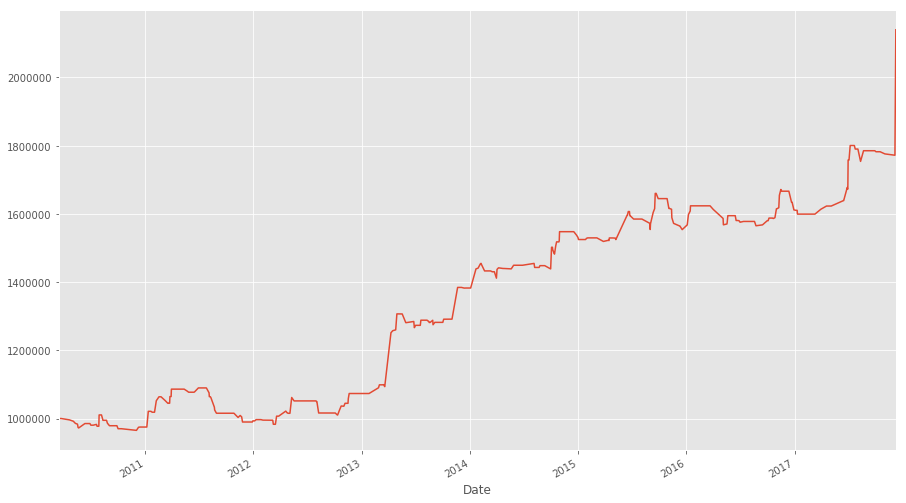

In [38] used 4.5039 MiB RAM in 0.66s, peaked 0.00 MiB above current, total RAM usage 241.84 MiB


In [38]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

In [39]:
spyder = web.DataReader("SPY", "yahoo", start, end)
spyder.iloc[[0,-1],:]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,112.769997,112.800003,111.389999,111.440002,95.218681,90637900
2017-12-08,265.160004,265.519989,264.029999,265.510010,265.510010,70726200


In [39] used -0.0273 MiB RAM in 4.54s, peaked 0.58 MiB above current, total RAM usage 241.81 MiB


In [40]:
batches = 1000000 // np.ceil(100 * spyder.ix[0,"Adj Close"]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.ix[0,"Adj Close"] # How much money is used to buy SPY
final_val = batches * batch * spyder.ix[-1,"Adj Close"] + (1000000 - trade_val) # Final value of the portfolio
final_val

/Users/1003946/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


2788058.9545000005

In [40] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 241.81 MiB


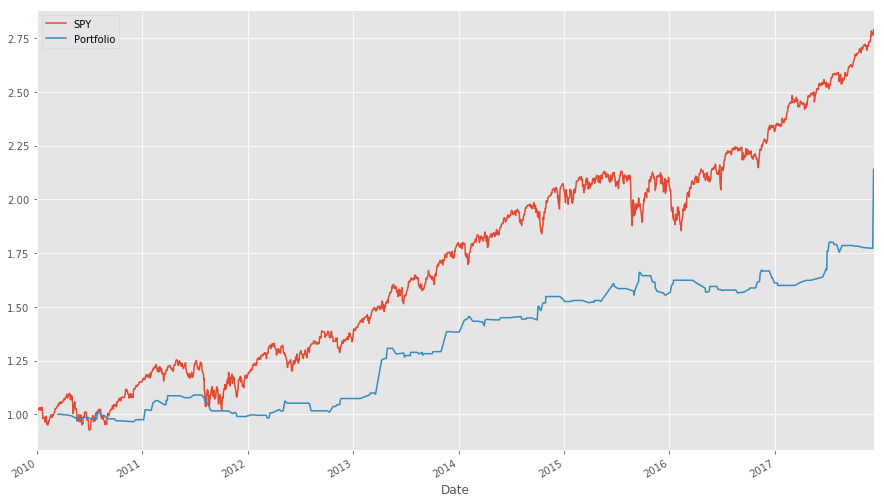

In [41] used 0.1055 MiB RAM in 0.84s, peaked 0.00 MiB above current, total RAM usage 241.92 MiB


In [41]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.ix[0, "Adj Close"]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench